### Initial PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load
df_etf = pd.read_csv(r"C:\Users\nicco\OneDrive\Desktop\08. Python\PhyDi\etfs-daily-1980-2024.csv")

# Keep ETFs
df_etf = df_etf[df_etf['SHRCD'] == 73]

# Make sure date is a datetime and sorted (optional but nice)
df_etf['date'] = pd.to_datetime(df_etf['date'])
df_etf = df_etf.sort_values('date')

# Convert RET to numeric, force non numeric like 'C' to NaN
df_etf['RET'] = pd.to_numeric(df_etf['RET'], errors='coerce')

# Pivot to date × PERMNO
df_ret = df_etf.pivot(index='date', columns='PERMNO', values='RET')

# Drop dates where everything is missing
df_ret = df_ret.dropna(how='all')

# Option 1: drop ETFs with no data at all (all NaN)
df_ret = df_ret.dropna(how='all', axis=1)

# Option 2: fill remaining NaNs, e.g. with column means instead of zero
df_ret_filled = df_ret.fillna(df_ret.mean())

# Standardize
scaler = StandardScaler()
ret_scaled = scaler.fit_transform(df_ret_filled)

# PCA
pca = PCA(n_components=5)
ret_pca = pca.fit_transform(ret_scaled)

explained_variance = pca.explained_variance_ratio_

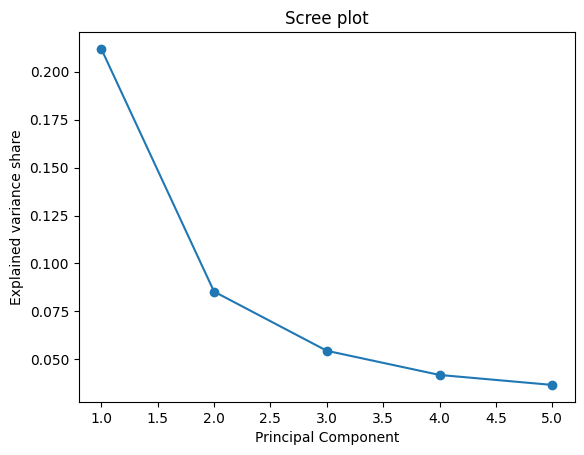

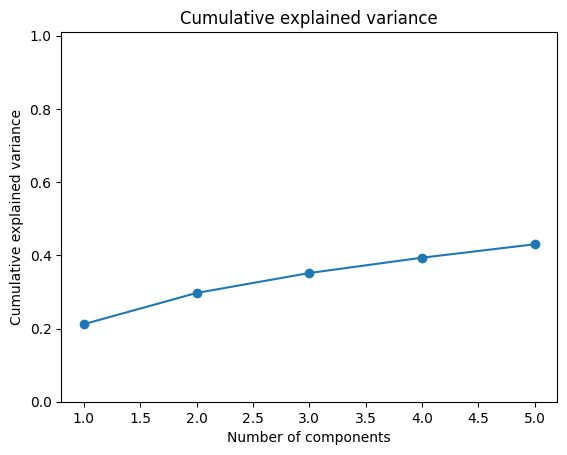

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Scree plot
plt.figure()
plt.plot(range(1, len(explained_variance) + 1),
         explained_variance,
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained variance share")
plt.title("Scree plot")
plt.show()

# Cumulative explained variance
cum_var = np.cumsum(explained_variance)
plt.figure()
plt.plot(range(1, len(cum_var) + 1),
         cum_var,
         marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance")
plt.ylim(0, 1.01)
plt.show()

In [69]:
import pandas as pd

# Load factors
factors = pd.read_csv(r"C:\Users\nicco\OneDrive\Desktop\08. Python\PhyDi\FF-6factors-1980-2024.csv")

# Make date a proper datetime index
# adapt depending on your actual date format
# if it is "YYYY-MM-DD":
factors['date'] = pd.to_datetime(factors['date'])

# if it is "YYYYMMDD" as integer, use:
# factors['date'] = pd.to_datetime(factors['date'].astype(str))

factors = factors.sort_values('date').set_index('date')

In [70]:
import numpy as np

pc_names = [f"PC{i+1}" for i in range(pca.n_components_)]
pc_ts = pd.DataFrame(ret_pca, index=df_ret.index, columns=pc_names)

# Align on overlapping dates
data = pc_ts.join(factors, how='inner')
data.head()

,PC1,PC2,PC3,PC4,PC5,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,
1993-02-01,0.009349,-0.008687,0.010357,0.009520,-0.001749,0.0084,-0.0055,0.0023,-0.0003,0.0018,0.0001,0.0071
1993-02-02,0.002331,-0.002166,0.002582,0.002374,-0.000436,0.0014,0.0012,0.0027,-0.0011,0.0033,0.0001,0.0059
1993-02-03,0.014211,-0.013204,0.015743,0.014471,-0.002659,0.0095,-0.0005,0.0026,0.0005,0.0000,0.0001,0.0008
1993-02-04,0.005233,-0.004863,0.005798,0.005329,-0.000979,0.0055,-0.0041,0.0069,-0.0024,0.0058,0.0001,0.0046
1993-02-05,-0.001623,0.001508,-0.001798,-0.001653,0.000304,-0.0033,-0.0056,0.0068,-0.0020,0.0089,0.0001,-0.0022


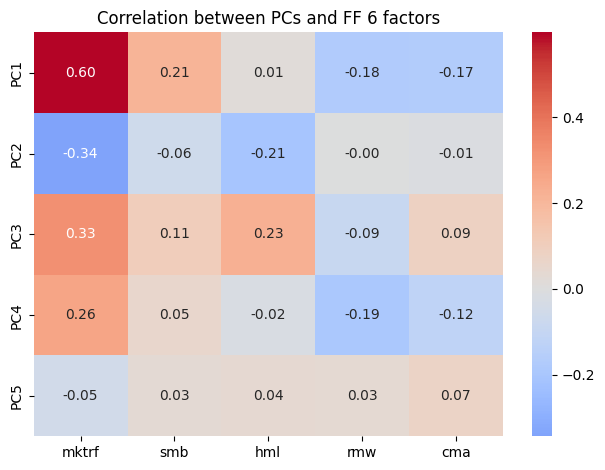

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns  # if you are ok with it

factor_cols = ['mktrf', 'smb', 'hml', 'rmw', 'cma']  # adjust to your names

corr_pc_factor = data[pc_names + factor_cols].corr().loc[pc_names, factor_cols]

plt.figure()
sns.heatmap(corr_pc_factor, annot=True, fmt=".2f", center=0, cmap="coolwarm")
plt.title("Correlation between PCs and FF 6 factors")
plt.tight_layout()
plt.show()

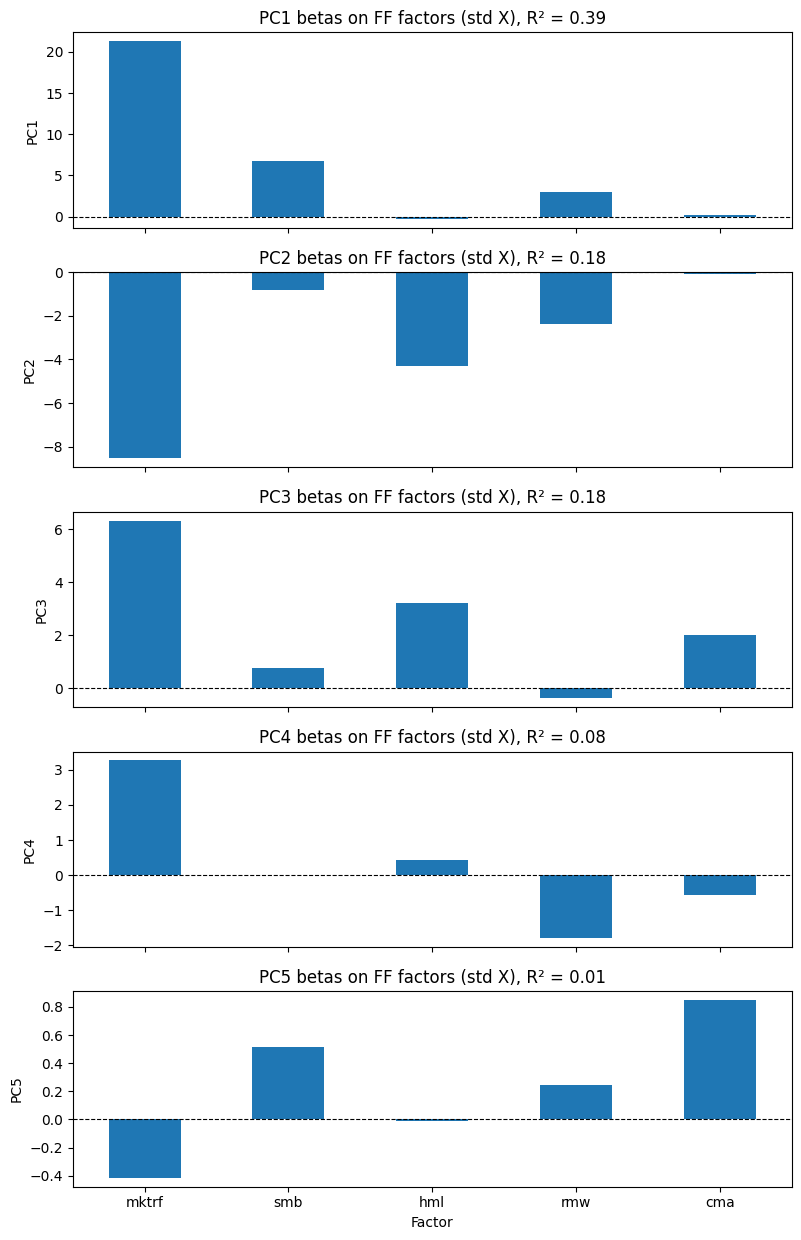

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# factor_cols = ['mktrf', 'smb', 'hml', 'rmw', 'cma']
# pc_names and data already defined above

# 1. Standardize factors (mean 0, std 1) so betas are on a sensible scale
X_raw = data[factor_cols]
X_std = (X_raw - X_raw.mean()) / X_raw.std(ddof=0)

# Optional: PCs are already roughly mean 0 if you used StandardScaler on returns.
# If you want them exactly standardized too:
# from sklearn.preprocessing import StandardScaler
# pc_std = pd.DataFrame(
#     StandardScaler().fit_transform(data[pc_names]),
#     index=data.index,
#     columns=pc_names
# )
# but using data[pc_names] is fine, variance is already 1 by construction.

betas_list = []
r2_list = []

for pc in pc_names:
    y = data[pc]  # PC series
    X = sm.add_constant(X_std)   # keep an intercept
    res = sm.OLS(y, X).fit()
    betas_list.append(res.params[factor_cols])  # only factor betas
    r2_list.append(res.rsquared)

betas_df = pd.DataFrame(betas_list, index=pc_names, columns=factor_cols)

# 2. Single figure with 5 subplots for betas, R^2 in titles
n_pc = len(pc_names)
fig, axes = plt.subplots(n_pc, 1, figsize=(8, 2.5 * n_pc), sharex=True)

if n_pc == 1:
    axes = [axes]

for i, pc in enumerate(pc_names):
    ax = axes[i]
    betas_df.loc[pc].plot(kind='bar', ax=ax)
    ax.axhline(0, linestyle='--', linewidth=0.8, color='black')
    ax.set_ylabel(pc)
    ax.set_title(f"{pc} betas on FF factors (std X), R² = {r2_list[i]:.2f}")

axes[-1].set_xlabel("Factor")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [82]:
import pandas as pd
import numpy as np

# 1) Wrap the standardized returns in a DataFrame
ret_scaled_df = pd.DataFrame(
    ret_scaled,
    index=df_ret_filled.index,
    columns=df_ret_filled.columns  # PERMNOs
)

# 2) Correlation between each ETF and each PC
corr_pc_etf = pd.DataFrame(index=df_ret_filled.columns, columns=pc_names)

for pc in pc_names:
    # corr of each ETF column with this PC time series
    corr_pc_etf[pc] = ret_scaled_df.corrwith(pc_ts[pc])

# 3) R^2: variance share of ETF j explained by PC k
r2_pc_etf = corr_pc_etf ** 2

# 4) Add TICKER and COMNAM metadata
etf_meta = df_etf[['PERMNO', 'TICKER', 'COMNAM']].drop_duplicates('PERMNO')

r2_with_meta = (
    r2_pc_etf
    .reset_index()
    .rename(columns={'index': 'PERMNO'})
    .merge(etf_meta, on='PERMNO', how='left')
)

# 5) For each PC, show ETFs with highest R^2
def show_representative_etfs(pc, n=10):
    cols = ['PERMNO', 'TICKER', 'COMNAM', pc]
    tmp = r2_with_meta[cols].sort_values(pc, ascending=False).head(n)
    print(f"\n=== {pc}: top {n} ETFs by R^2 (variance explained by this PC alone) ===")
    print(tmp.to_string(index=False))

for pc in pc_names:
    show_representative_etfs(pc, n=10)

C:\Users\nicco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\nicco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



=== PC1: top 10 ETFs by R^2 (variance explained by this PC alone) ===
 PERMNO TICKER                         COMNAM      PC1
  17454   GSEW      GOLDMAN SACHS E T F TRUST 0.784266
  15102   CRBN                  ISHARES TRUST 0.781992
  18095   ESGV            VANGUARD WORLD FUND 0.781381
  17020   SCHK         SCHWAB STRATEGIC TRUST 0.780332
  17016   BIBL     NORTHERN LIGHTS FUND TR IV 0.778976
  18188   GOAT     VANECK VECTORS E T F TRUST 0.778007
  15249     XT                  ISHARES TRUST 0.776892
  16135   FLQG FRANKLIN TEMPLETON E T F TRUST 0.776322
  18005   PEXL              PACER FUNDS TRUST 0.771694
  18920   AVUS   AMERICAN CENTURY E T F TRUST 0.768556

=== PC2: top 10 ETFs by R^2 (variance explained by this PC alone) ===
 PERMNO TICKER                       COMNAM      PC2
  24412   ITDF                ISHARES TRUST 0.417726
  24410   ITDH                ISHARES TRUST 0.416447
  24235   BAMA   NORTHERN LIGHTS FUND TR IV 0.416393
  24181   AVLC AMERICAN CENTURY E T F TRU

In [84]:
# Total R^2 from all 5 PCs (since PCs are orthogonal)
r2_total = r2_pc_etf.sum(axis=1)   # index = PERMNO

r2_total_meta = (
    r2_total.rename('R2_total')
    .reset_index()
    .merge(etf_meta, on='PERMNO', how='left')
    .sort_values('R2_total', ascending=False)
)

print("\n=== ETFs best captured by the first 5 PCs (total R^2) ===")
print(r2_total_meta.head(20).to_string(index=False))


=== ETFs best captured by the first 5 PCs (total R^2) ===
 PERMNO  R2_total TICKER                     COMNAM
  21375  0.925086   DFUS    DIMENSIONAL E T F TRUST
  21394  0.921615   FDWM   FIDELITY COVINGTON TRUST
  17454  0.921039   GSEW  GOLDMAN SACHS E T F TRUST
  21393  0.920617   FSST   FIDELITY COVINGTON TRUST
  20911  0.919979   LCTU      BLACKROCK E T F TRUST
  21387  0.916127   VOTE      ENGINE NO 1 ETF TRUST
  21378  0.910970   DFAC    DIMENSIONAL E T F TRUST
  20073  0.908030   DFAU    DIMENSIONAL E T F TRUST
  21421  0.907671   TSPA     T ROWE PRICE E T F INC
  22014  0.907164   FEUS           FLEXSHARES TRUST
  21660  0.906843   LEXI         LISTED FUNDS TRUST
  15686  0.905677   JHML   JOHN HANCOCK E T F TRUST
  92585  0.905468   ACWI              ISHARES TRUST
  21364  0.904785   ITAN  ALPHA ARCHITECT ETF TRUST
  20228  0.901197   JCTR     J P MORGAN E T F TRUST
  17020  0.898420   SCHK     SCHWAB STRATEGIC TRUST
  15687  0.898351   JHMM   JOHN HANCOCK E T F TRUST
  214

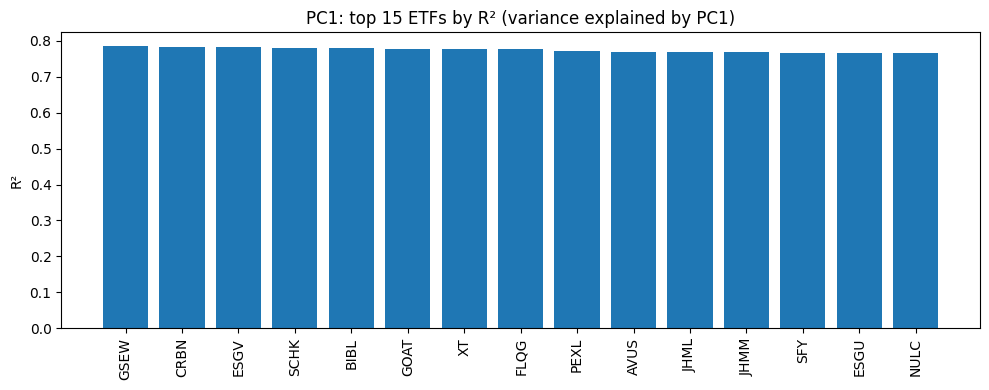

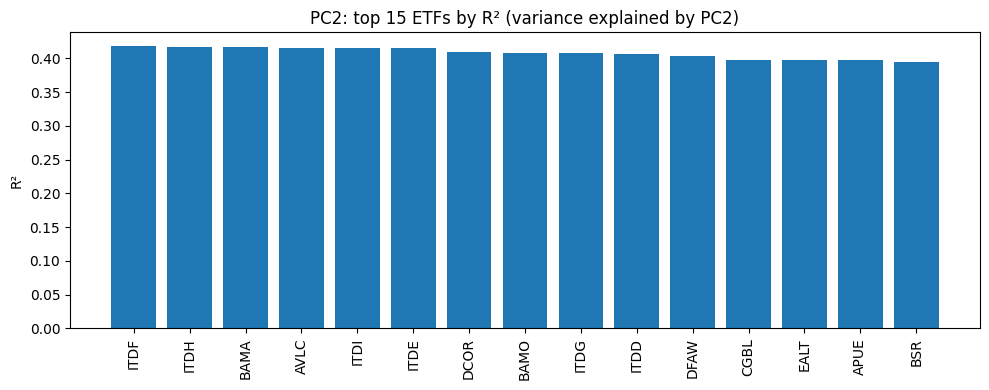

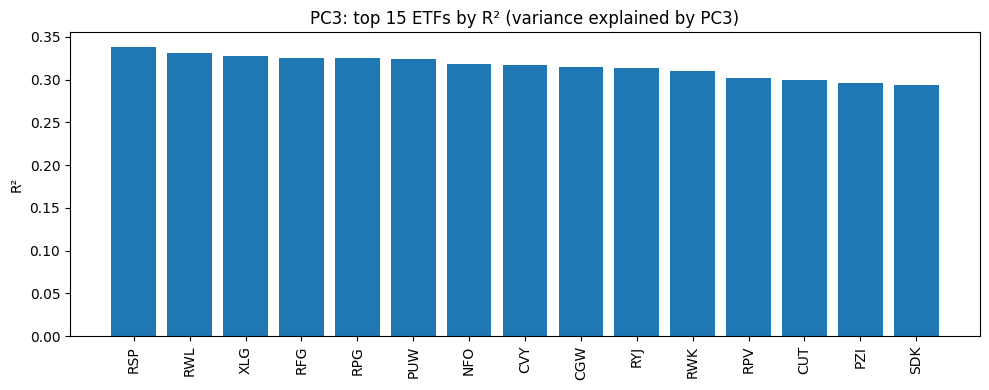

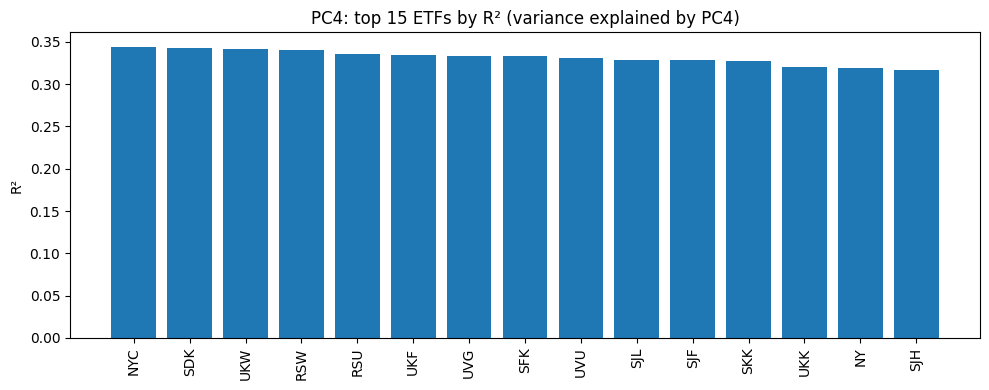

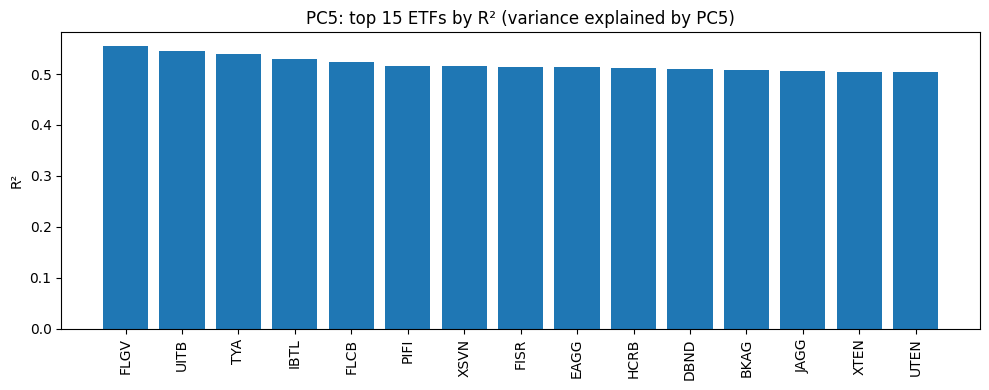

In [85]:
import matplotlib.pyplot as plt

for pc in pc_names:
    # R² for this PC and ETF tickers
    tmp = r2_with_meta[['TICKER', pc]].dropna()

    # top 15 ETFs by R² (most variance explained by this PC)
    top = tmp.sort_values(pc, ascending=False).head(15)

    plt.figure(figsize=(10, 4))
    plt.bar(top['TICKER'], top[pc])
    plt.xticks(rotation=90)
    plt.title(f"{pc}: top 15 ETFs by R² (variance explained by {pc})")
    plt.ylabel("R²")
    plt.tight_layout()
    plt.show()


### Simulations

### ETF universe + optimization/simulation framework
This section builds a filtered ETF universe (top-N per category) and runs portfolio simulations.
You can supply a local ETF universe CSV with category + size/liquidity fields.


In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


import json
import urllib.request

ETFDB_API_URL = "https://etfdb.com/api/screener/"


def _etfdb_post(payload):
    req = urllib.request.Request(ETFDB_API_URL, method="POST")
    req.add_header("Content-Type", "application/json")
    req.add_header("User-Agent", "Mozilla/5.0")
    with urllib.request.urlopen(req, data=json.dumps(payload).encode("utf-8"), timeout=30) as resp:
        return json.loads(resp.read().decode("utf-8", errors="ignore"))


def etfdb_available_filters():
    data = _etfdb_post({})
    return data.get("count", {})


def _parse_money_mm(text):
    # ETFdb assets are shown in $MM (millions)
    if text is None:
        return np.nan
    s = str(text).replace("$", "").replace(",", "").strip()
    if not s:
        return np.nan
    try:
        return float(s)
    except ValueError:
        return np.nan


def _parse_number(text):
    if text is None:
        return np.nan
    s = str(text).replace(",", "").replace("$", "").replace("%", "").strip()
    if not s:
        return np.nan
    try:
        return float(s)
    except ValueError:
        return np.nan


def fetch_etfdb_top_by_category(category_field, top_n=10, sort_by="assets", per_page=50):
    counts = etfdb_available_filters()
    if category_field not in counts:
        raise ValueError(f"Unknown category_field: {category_field}")
    values = list(counts[category_field].keys())
    rows = []
    for val in values:
        payload = {
            "page": 1,
            "per_page": max(per_page, top_n),
            "sort_by": sort_by,
            "sort_direction": "desc",
            category_field: [val],
        }
        resp = _etfdb_post(payload)
        records = resp.get("data", [])
        for rec in records[:top_n]:
            symbol = rec.get("symbol", {})
            name = rec.get("name", {})
            rows.append({
                "TICKER": symbol.get("text", symbol) if isinstance(symbol, dict) else symbol,
                "NAME": name.get("text", name) if isinstance(name, dict) else name,
                "AUM": _parse_money_mm(rec.get("assets")) * 1_000_000,
                "ADV": _parse_number(rec.get("average_volume")),
                "ASSET_CLASS": rec.get("asset_class"),
                "CATEGORY_TYPE": category_field,
                "CATEGORY": val,
                "SOURCE": "ETFDB",
            })
    return pd.DataFrame(rows).drop_duplicates(subset=["TICKER", "CATEGORY_TYPE", "CATEGORY"])


def build_etfdb_universe(category_fields=("asset_class", "sizes", "investment_styles"), top_n=10):
    frames = []
    for field in category_fields:
        frames.append(fetch_etfdb_top_by_category(field, top_n=top_n))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)


ETF_UNIVERSE_CSV = r"etf_universe.csv"

# Expected columns in the ETF universe file:
# TICKER, CATEGORY, AUM, ADV, PROVIDER (AUM in USD, ADV in USD or shares)

def load_etf_universe(path):
    df = pd.read_csv(path)
    # Normalize columns to upper-case names we expect
    df.columns = [c.strip().upper() for c in df.columns]
    needed = {"TICKER", "CATEGORY"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"ETF universe missing columns: {sorted(missing)}")
    return df

def select_top_etfs_by_category(df, top_n=5, score_cols=("AUM", "ADV")):
    df = df.copy()
    # Build a simple importance score if columns exist
    score = pd.Series(0, index=df.index, dtype=float)
    for col in score_cols:
        if col in df.columns:
            score += pd.to_numeric(df[col], errors="coerce").fillna(0)
    if score.sum() == 0:
        # fallback: keep natural order within category
        df["_score"] = range(len(df))
    else:
        df["_score"] = score
    df = df.sort_values(["CATEGORY", "_score"], ascending=[True, False])
    out = df.groupby("CATEGORY", group_keys=False).head(top_n)
    return out.drop(columns=["_score"])

def build_returns_panel(df_etf, tickers, min_history=252):
    # df_etf is your CRSP-style panel with date, TICKER, RET
    df = df_etf.copy()
    df["RET"] = pd.to_numeric(df["RET"], errors="coerce")
    df["date"] = pd.to_datetime(df["date"])
    df = df[df["TICKER"].isin(tickers)]
    # De-duplicate date/ticker pairs (ticker reuse or multiple share classes)
    df = df.sort_values("date")
    df = (
        df.groupby(["date", "TICKER"], as_index=False)["RET"]
        .last()
    )
    ret = df.pivot(index="date", columns="TICKER", values="RET")
    # Keep ETFs with enough history
    enough = ret.notna().sum() >= min_history
    ret = ret.loc[:, enough]
    # Fill remaining gaps with column means (keeps scale in returns)
    ret = ret.fillna(ret.mean())
    return ret.sort_index()

def portfolio_metrics(ret, rf=0.0, periods_per_year=252):
    mean = ret.mean() * periods_per_year
    vol = ret.std(ddof=0) * np.sqrt(periods_per_year)
    sharpe = np.nan if vol == 0 else (mean - rf) / vol
    cum = (1 + ret).cumprod()
    peak = cum.cummax()
    drawdown = (cum / peak) - 1
    max_dd = drawdown.min()
    return {"ann_return": mean, "ann_vol": vol, "sharpe": sharpe, "max_dd": max_dd}

def market_vs_idio_risk(port_ret, mkt_ret):
    # Simple CAPM decomposition: var = beta^2 * var(mkt) + var(resid)
    aligned = pd.concat([port_ret, mkt_ret], axis=1).dropna()
    if aligned.empty:
        return {"beta": np.nan, "mkt_var": np.nan, "idio_var": np.nan, "idio_share": np.nan}
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned.iloc[:, 1])
    res = sm.OLS(y, X).fit()
    beta = res.params.iloc[1]
    mkt_var = (beta ** 2) * aligned.iloc[:, 1].var(ddof=0)
    idio_var = res.resid.var(ddof=0)
    total = y.var(ddof=0)
    idio_share = np.nan if total == 0 else idio_var / total
    return {"beta": beta, "mkt_var": mkt_var, "idio_var": idio_var, "idio_share": idio_share}

def simulate_portfolios(returns, mkt_ret=None,
                        n_portfolios=500, etf_counts=(5, 10, 20),
                        random_state=42):
    rng = np.random.default_rng(random_state)
    tickers = list(returns.columns)
    results = []
    for k in etf_counts:
        if k > len(tickers):
            continue
        for _ in range(n_portfolios):
            picks = rng.choice(tickers, size=k, replace=False)
            port_ret = returns[picks].mean(axis=1)  # equal-weight
            metrics = portfolio_metrics(port_ret)
            risk = {}
            if mkt_ret is not None:
                risk = market_vs_idio_risk(port_ret, mkt_ret)
            results.append({"n_etfs": k, "tickers": ",".join(picks), **metrics, **risk})
    return pd.DataFrame(results)

# --- Factor model + optimization helpers ---

def load_factors_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    if "date" not in df.columns:
        raise ValueError("Factors file must include a date column")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")
    return df


def _maybe_scale_factors(factors):
    # If factors look like percent (e.g. 0.5 for 0.5%), scale to decimals.
    # Heuristic: median abs value > 1 suggests percent scale.
    med = factors.abs().median().median()
    if pd.notna(med) and med > 1:
        return factors / 100.0
    return factors


def estimate_factor_model(returns, factors, factor_cols=None):
    if factor_cols is None:
        factor_cols = [c for c in factors.columns if c.lower() not in ("rf",)]
    fac = factors[factor_cols].copy()
    fac = _maybe_scale_factors(fac)
    aligned = returns.join(fac, how="inner")
    fac = aligned[factor_cols]
    y = aligned[returns.columns]
    X = sm.add_constant(fac)

    betas = pd.DataFrame(index=returns.columns, columns=factor_cols, dtype=float)
    idio_var = pd.Series(index=returns.columns, dtype=float)

    for col in y.columns:
        res = sm.OLS(y[col], X, missing="drop").fit()
        betas.loc[col] = res.params[factor_cols]
        idio_var[col] = res.resid.var(ddof=0)

    return betas, fac.cov(ddof=0), idio_var


def factor_model_cov(betas, factor_cov, idio_var):
    B = betas.values
    F = factor_cov.values
    D = np.diag(idio_var.values)
    cov = B @ F @ B.T + D
    return pd.DataFrame(cov, index=betas.index, columns=betas.index)


def annualize_stats(returns, periods_per_year=252):
    mu = returns.mean() * periods_per_year
    cov = returns.cov(ddof=0) * periods_per_year
    return mu, cov


def optimize_min_variance(cov):
    cov = np.asarray(cov)
    n = cov.shape[0]
    inv = np.linalg.pinv(cov)
    ones = np.ones(n)
    w = inv @ ones
    w = w / (ones @ inv @ ones)
    return w


def optimize_target_return(mu, cov, target):
    mu = np.asarray(mu)
    cov = np.asarray(cov)
    n = cov.shape[0]
    inv = np.linalg.pinv(cov)
    ones = np.ones(n)
    A = ones @ inv @ ones
    B = ones @ inv @ mu
    C = mu @ inv @ mu
    denom = A * C - B * B
    if denom == 0:
        return optimize_min_variance(cov)
    lam = (C - B * target) / denom
    gamma = (A * target - B) / denom
    w = inv @ (lam * ones + gamma * mu)
    return w


def optimize_max_sharpe(mu, cov, rf=0.0):
    mu = np.asarray(mu)
    cov = np.asarray(cov)
    excess = mu - rf
    inv = np.linalg.pinv(cov)
    w = inv @ excess
    if w.sum() != 0:
        w = w / w.sum()
    return w


def optimize_long_only(mu, cov, target=None, rf=0.0, objective="min_var", n_random=2000, random_state=42):
    try:
        from scipy.optimize import minimize
    except Exception:
        minimize = None

    mu = np.asarray(mu)
    cov = np.asarray(cov)
    n = len(mu)

    if minimize is None:
        # Fallback: random search
        rng = np.random.default_rng(random_state)
        best_w = None
        best_val = np.inf
        for _ in range(n_random):
            w = rng.dirichlet(np.ones(n))
            if target is not None and (w @ mu) < target:
                continue
            if objective == "max_sharpe":
                vol = np.sqrt(w @ cov @ w)
                val = -((w @ mu) - rf) / vol if vol > 0 else np.inf
            else:
                val = w @ cov @ w
            if val < best_val:
                best_val = val
                best_w = w
        return best_w if best_w is not None else np.ones(n) / n

    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    if target is not None:
        cons.append({"type": "ineq", "fun": lambda w: (w @ mu) - target})

    bounds = [(0.0, 1.0)] * n
    x0 = np.ones(n) / n

    def obj_min_var(w):
        return w @ cov @ w

    def obj_max_sharpe(w):
        vol = np.sqrt(w @ cov @ w)
        return -((w @ mu) - rf) / vol if vol > 0 else np.inf

    obj = obj_max_sharpe if objective == "max_sharpe" else obj_min_var
    res = minimize(obj, x0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        return x0
    return res.x


In [14]:
# 0) Build ETF universe from ETFdb (optional)
# Set REFRESH_UNIVERSE = False to skip the download.
REFRESH_UNIVERSE = True

if REFRESH_UNIVERSE:
    etfdb_universe = build_etfdb_universe(
        category_fields=("asset_class", "sizes", "investment_styles"),
        top_n=5,
    )
    etfdb_universe.to_csv(ETF_UNIVERSE_CSV, index=False)

# If df_etf is not defined yet, load it here.
if "df_etf" not in globals():
    df_etf = pd.read_csv(r"etfs-daily-1980-2024.csv")
    df_etf = df_etf[df_etf['SHRCD'] == 73]

FACTORS_CSV = r"FF-6factors-1980-2024.csv"
# If factors are not defined yet, try loading them.
if "factors" not in globals():
    try:
        factors = load_factors_csv(FACTORS_CSV)
    except FileNotFoundError:
        factors = None

# 1) Load ETF universe (top-N per category)
# Fill or replace ETF_UNIVERSE_CSV with a real data source for top ETFs.

etf_universe = load_etf_universe(ETF_UNIVERSE_CSV)
top_etfs = select_top_etfs_by_category(etf_universe, top_n=5)
tickers = top_etfs["TICKER"].dropna().unique().tolist()

# 2) Build returns panel for selected tickers
ret_panel = build_returns_panel(df_etf, tickers, min_history=252)

# 3) Simulate diversification + risk decomposition
# If you have factor data loaded, set mkt_ret to your market series
mkt_ret = None
if factors is not None and "mktrf" in factors.columns:
    mkt_ret = factors["mktrf"].astype(float) / 100.0  # if percent

sim = simulate_portfolios(ret_panel, mkt_ret=mkt_ret, n_portfolios=300, etf_counts=(5, 10, 20))
sim.head()


,n_etfs,tickers,ann_return,ann_vol,sharpe,max_dd,beta,mkt_var,idio_var,idio_share
0,5,"SSO,IWM,RSP,BND,ZIG",0.115706,0.137645,0.840608,-0.465767,63.238661,0.000054,0.000021,0.275108
1,5,"XLG,BNDX,MOAT,SVOL,SPXL",0.160627,0.110039,1.459721,-0.337348,39.716627,0.000021,0.000027,0.552616
2,5,"MDY,UVXY,IWR,IJR,DIVO",-0.103494,0.140373,-0.737278,-0.977064,21.036443,0.000006,0.000072,0.922872
3,5,"MTUM,EUFN,IYR,IWM,USMV",0.114391,0.130009,0.879874,-0.388191,56.913150,0.000044,0.000023,0.341870
4,5,"DFNL,VBR,UVIX,FTLS,RECS",-0.124249,0.090092,-1.379126,-0.985909,19.869138,0.000005,0.000027,0.832963


In [15]:
etfdb_universe

,TICKER,NAME,AUM,ADV,ASSET_CLASS,CATEGORY_TYPE,CATEGORY,SOURCE
0,IBIT,iShares Bitcoin Trust ETF,6.791400e+10,64697879.0,Currency,asset_class,currency,ETFDB
1,FBTC,Fidelity Wise Origin Bitcoin Fund,1.780900e+10,6591486.0,Currency,asset_class,currency,ETFDB
2,GBTC,Grayscale Bitcoin Trust ETF,1.454600e+10,5641783.0,Currency,asset_class,currency,ETFDB
3,ETHA,iShares Ethereum Trust ETF,1.029900e+10,50309570.0,Currency,asset_class,currency,ETFDB
4,BTC,Grayscale Bitcoin Mini Trust ETF,4.258000e+09,2609962.0,Currency,asset_class,currency,ETFDB
...,...,...,...,...,...,...,...,...
166,MOAT,VanEck Morningstar Wide Moat ETF,1.301200e+10,859131.0,Equity,investment_styles,Wide Moat,ETFDB
167,MOTI,VanEck Morningstar International Moat ETF,1.960000e+08,9352.0,Equity,investment_styles,Wide Moat,ETFDB
168,BETZ,Roundhill Sports Betting & iGaming ETF,6.400000e+07,18395.0,Equity,investment_styles,Wide Moat,ETFDB
169,AADR,AdvisorShares Dorsey Wright ADR ETF,4.700000e+07,2580.0,Equity,investment_styles,Wide Moat,ETFDB


In [9]:
sim

,n_etfs,tickers,ann_return,ann_vol,sharpe,max_dd
0,5,"SSO,IWM,RSP,BND,ZIG",0.115706,0.137645,0.840608,-0.465767
1,5,"XLG,BNDX,MOAT,SVOL,SPXL",0.160627,0.110039,1.459721,-0.337348
2,5,"MDY,UVXY,IWR,IJR,DIVO",-0.103494,0.140373,-0.737278,-0.977064
3,5,"MTUM,EUFN,IYR,IWM,USMV",0.114391,0.130009,0.879874,-0.388191
4,5,"DFNL,VBR,UVIX,FTLS,RECS",-0.124249,0.090092,-1.379126,-0.985909
...,...,...,...,...,...,...
895,20,"DUSA,CGDV,PFFD,XMMO,BETZ,FTLS,HEFA,VYM,IYR,IWM...",0.133735,0.098910,1.352080,-0.296954
896,20,"JPST,FTLS,SSO,PTLC,VGT,GLD,MGV,XBI,TQQQ,PJAN,S...",0.123163,0.091570,1.345011,-0.264972
897,20,"XLK,EEMV,AMLP,IDMO,ITA,VOO,SLYV,JPST,HEFA,AOR,...",0.101627,0.088061,1.154053,-0.286617
898,20,"AVDE,MOTI,HEDJ,QAI,BND,MOAT,VGIT,BUFR,SSO,VTV,...",0.090122,0.071133,1.266940,-0.264728


In [17]:
# 4) Quick summary views
sim.groupby("n_etfs")[["ann_return", "ann_vol", "sharpe", "max_dd", "idio_share"]].mean()
# sim.groupby("n_etfs")[["ann_return", "ann_vol", "sharpe", "max_dd"]].mean()


,ann_return,ann_vol,sharpe,max_dd,idio_share
n_etfs,,,,,
5,0.097654,0.103184,1.007442,-0.379701,0.502551
10,0.099587,0.091004,1.094153,-0.326757,0.462235
20,0.099414,0.088468,1.120379,-0.289395,0.402137


### Optimization + factor-model simulations
This section compares sample-covariance vs factor-model covariance and builds efficient frontiers.


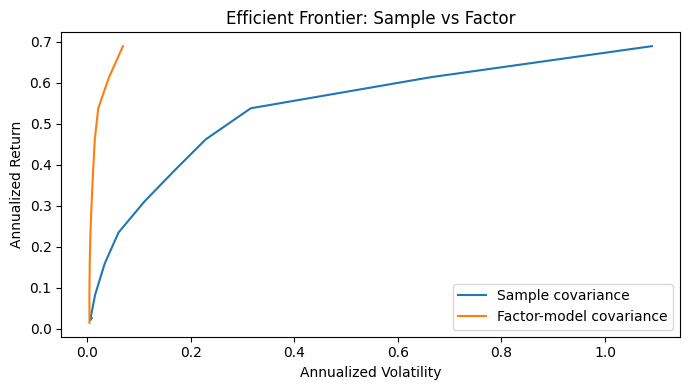

,model,sharpe
0,sample,12.036545
1,factor,10.611720


In [19]:
import matplotlib.pyplot as plt

# Config
EST_YEARS = 5
HORIZON_YEARS = 15  # longer horizon => lower risk aversion (example)
RISK_FREE = 0.0
LONG_ONLY = True

def slice_recent(returns, years):
    end = returns.index.max()
    start = end - pd.DateOffset(years=years)
    return returns.loc[returns.index >= start]

# Optional: restrict to a category type or specific categories
# Example: only Equity asset class
# eq_tickers = etf_universe[(etf_universe['CATEGORY_TYPE'] == 'asset_class') & (etf_universe['CATEGORY'].str.lower() == 'equity')]['TICKER']
# ret_panel = ret_panel.loc[:, ret_panel.columns.intersection(eq_tickers)]

ret_est = slice_recent(ret_panel, EST_YEARS)
mu_s, cov_s = annualize_stats(ret_est)

# Factor-model covariance (if factors are available)
cov_f = None
if factors is not None:
    factor_cols = [c for c in factors.columns if c.lower() not in ('rf',)]
    betas, fac_cov, idio_var = estimate_factor_model(ret_est, factors, factor_cols=factor_cols)
    cov_f = factor_model_cov(betas, fac_cov, idio_var)

def compute_frontier(mu, cov, n_points=25, long_only=True):
    targets = np.linspace(mu.min(), mu.max(), n_points)
    vols, rets = [], []
    for t in targets:
        if long_only:
            w = optimize_long_only(mu, cov, target=t, objective='min_var')
        else:
            w = optimize_target_return(mu, cov, target=t)
        vols.append(np.sqrt(w @ cov @ w))
        rets.append(w @ mu)
    return pd.DataFrame({'vol': vols, 'ret': rets, 'target': targets})

front_s = compute_frontier(mu_s.values, cov_s.values, n_points=25, long_only=LONG_ONLY)

plt.figure(figsize=(7, 4))
plt.plot(front_s['vol'], front_s['ret'], label='Sample covariance')

if cov_f is not None:
    # Use sample mean with factor-model covariance
    front_f = compute_frontier(mu_s.values, cov_f.values, n_points=25, long_only=LONG_ONLY)
    plt.plot(front_f['vol'], front_f['ret'], label='Factor-model covariance')

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier: Sample vs Factor')
plt.legend()
plt.tight_layout()
plt.show()

# Max Sharpe portfolios
w_s = optimize_long_only(mu_s.values, cov_s.values, objective='max_sharpe', rf=RISK_FREE) if LONG_ONLY else optimize_max_sharpe(mu_s.values, cov_s.values, rf=RISK_FREE)
sharpe_s = (w_s @ mu_s.values - RISK_FREE) / np.sqrt(w_s @ cov_s.values @ w_s)

if cov_f is not None:
    w_f = optimize_long_only(mu_s.values, cov_f.values, objective='max_sharpe', rf=RISK_FREE) if LONG_ONLY else optimize_max_sharpe(mu_s.values, cov_f.values, rf=RISK_FREE)
    sharpe_f = (w_f @ mu_s.values - RISK_FREE) / np.sqrt(w_f @ cov_f.values @ w_f)
else:
    w_f = None
    sharpe_f = np.nan

summary = pd.DataFrame({
    'model': ['sample', 'factor'],
    'sharpe': [sharpe_s, sharpe_f]
})
summary


In [20]:
factors

,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,
1980-01-02,-0.0204,0.0020,0.0108,-0.0096,0.0076,0.0004,-0.0129
1980-01-03,-0.0073,-0.0088,0.0033,-0.0030,0.0016,0.0004,-0.0072
1980-01-04,0.0132,0.0062,-0.0037,-0.0009,-0.0059,0.0004,0.0062
1980-01-07,0.0039,0.0027,0.0005,-0.0044,0.0007,0.0004,0.0038
1980-01-08,0.0193,-0.0032,-0.0069,0.0068,-0.0031,0.0004,0.0003
...,...,...,...,...,...,...,...
2025-10-27,0.0117,-0.0081,-0.0121,-0.0023,-0.0119,0.0002,0.0047
2025-10-28,0.0018,-0.0034,-0.0061,0.0063,-0.0101,0.0002,0.0080
2025-10-29,-0.0009,-0.0098,-0.0081,0.0030,-0.0137,0.0002,0.0194


### Top risk-adjusted portfolios: overlap + structure


In [22]:
# Analyze top risk-adjusted portfolios from the simulation output `sim`
# Assumes `sim` exists and contains 'sharpe' and 'tickers' columns.

TOP_PCT = 0.05  # top 5% by Sharpe

if 'sim' not in globals() or sim.empty:
    raise ValueError('Run the simulation cell first to create `sim`.')

sim_sorted = sim.dropna(subset=['sharpe']).sort_values('sharpe', ascending=False)
top_n = max(1, int(len(sim_sorted) * TOP_PCT))
top = sim_sorted.head(top_n).copy()

# Parse tickers into lists
top['ticker_list'] = top['tickers'].str.split(',')

# Most common ETFs in top portfolios
all_tickers = pd.Series([t for lst in top['ticker_list'] for t in lst])
ticker_counts = all_tickers.value_counts().rename('count')
ticker_freq = (ticker_counts / top_n).rename('freq_top')
top_ticker_summary = pd.concat([ticker_counts, ticker_freq], axis=1).head(20)

# Map tickers to asset class (from ETFdb universe if available)
asset_map = None
if 'etf_universe' in globals():
    tmp = etf_universe.copy()
    if 'CATEGORY_TYPE' in tmp.columns and 'CATEGORY' in tmp.columns and 'TICKER' in tmp.columns:
        tmp = tmp[tmp['CATEGORY_TYPE'].str.lower() == 'asset_class']
        asset_map = tmp[['TICKER', 'CATEGORY']].drop_duplicates('TICKER').set_index('TICKER')['CATEGORY']

def portfolio_asset_mix(ticker_list, asset_map):
    if asset_map is None:
        return pd.Series(dtype=float)
    classes = pd.Series(ticker_list).map(asset_map).fillna('Unknown')
    return classes.value_counts(normalize=True)

# Average asset-class mix across top portfolios
if asset_map is not None:
    mixes = top['ticker_list'].apply(lambda x: portfolio_asset_mix(x, asset_map))
    mix_df = mixes.fillna(0).apply(lambda s: s.reindex(s.index), axis=1)
    avg_mix = mix_df.fillna(0).mean().sort_values(ascending=False)
else:
    avg_mix = pd.Series(dtype=float)

# Summary metrics for top vs overall
metric_cols = ['ann_return', 'ann_vol', 'sharpe', 'max_dd', 'idio_share']
summary_all = sim[metric_cols].mean(numeric_only=True)
summary_top = top[metric_cols].mean(numeric_only=True)
summary = pd.concat([summary_all.rename('all'), summary_top.rename('top')], axis=1)

display(top_ticker_summary)

display(avg_mix)

display(summary)


,count,freq_top
IBIT,29,0.644444
JOET,8,0.177778
JEPQ,8,0.177778
AOR,8,0.177778
CGBL,7,0.155556
FNOV,6,0.133333
FTLS,6,0.133333
DBMF,6,0.133333
CTA,6,0.133333
ISMD,6,0.133333


Unknown            0.641111
currency           0.080000
alternatives       0.067778
multi-asset        0.046667
commodity          0.043333
real estate        0.034444
preferred stock    0.031111
bond               0.025556
equity             0.021111
volatility         0.008889
dtype: float64

,all,top
ann_return,0.098885,0.141989
ann_vol,0.094218,0.071125
sharpe,1.073991,2.000117
max_dd,-0.331951,-0.236924
idio_share,0.455641,0.563254


In [23]:
etfdb_universe

,TICKER,NAME,AUM,ADV,ASSET_CLASS,CATEGORY_TYPE,CATEGORY,SOURCE
0,IBIT,iShares Bitcoin Trust ETF,6.791400e+10,64697879.0,Currency,asset_class,currency,ETFDB
1,FBTC,Fidelity Wise Origin Bitcoin Fund,1.780900e+10,6591486.0,Currency,asset_class,currency,ETFDB
2,GBTC,Grayscale Bitcoin Trust ETF,1.454600e+10,5641783.0,Currency,asset_class,currency,ETFDB
3,ETHA,iShares Ethereum Trust ETF,1.029900e+10,50309570.0,Currency,asset_class,currency,ETFDB
4,BTC,Grayscale Bitcoin Mini Trust ETF,4.258000e+09,2609962.0,Currency,asset_class,currency,ETFDB
...,...,...,...,...,...,...,...,...
166,MOAT,VanEck Morningstar Wide Moat ETF,1.301200e+10,859131.0,Equity,investment_styles,Wide Moat,ETFDB
167,MOTI,VanEck Morningstar International Moat ETF,1.960000e+08,9352.0,Equity,investment_styles,Wide Moat,ETFDB
168,BETZ,Roundhill Sports Betting & iGaming ETF,6.400000e+07,18395.0,Equity,investment_styles,Wide Moat,ETFDB
169,AADR,AdvisorShares Dorsey Wright ADR ETF,4.700000e+07,2580.0,Equity,investment_styles,Wide Moat,ETFDB
